In [1]:
from tensorflow.keras.applications import * #Efficient Net included here
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import pandas as pd
from sklearn import model_selection
from tqdm import tqdm
from tensorflow.keras import optimizers
import tensorflow as tf
#Use this to check if the GPU is configured correctly
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9361267438907123948
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4848943104
locality {
  bus_id: 1
  links {
  }
}
incarnation: 446274626333919923
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:2b:00.0, compute capability: 6.1"
]


EfficientNet 

Core:

    - model scaling --> Compound scaling (Scale Depth, Width, and Resolution) art of balancing
<center><img src="https://miro.medium.com/max/1000/0*6HOeHlkq2wmZLmQs"></center>

if we have double resources available than what a model is currently using, we can take find ø using 2ø = 2 

This technique scales Network in aspect as discuss previously.

<center><img src="https://miro.medium.com/max/700/0*GW6hb6YwdWXQNDiu"></center>

EfficientNet-B0 is used as a based-model for B1-7

This is how B0 looks like. B0 is a mobile model with about 11M Trainable params. There are 7 inverted residual blocks with squeeze & excitation block along with swish activation.

Swish(x) = x * sigmoid(x)

<center><img src="https://miro.medium.com/max/700/0*6ezHy0HX_lCrJGRS"></center>

In [2]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [121]:
import tensorflow_datasets as tfds

batch_size = 64

dataset_name = "stanford_dogs"
(ds_train,ds_test), ds_info = tfds.load(
    dataset_name, split=["train","test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

In [122]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

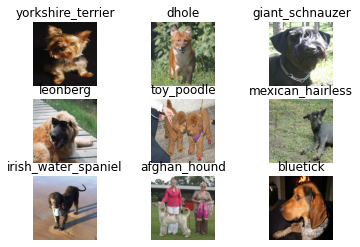

In [123]:
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

In [124]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers

# img_augmentation = Sequential(
#     [
#         layers.RandomRotation(factor=0.15),
#         layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
#         layers.RandomFlip(),
#         layers.RandomContrast(factor=0.1),
#     ],
#     name="img_augmentation",
# )

In [125]:
# for image, label in ds_train.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         aug_img = img_augmentation(tf.expand_dims(image, axis=0))
#         plt.imshow(aug_img[0].numpy().astype("uint8"))
#         plt.title("{}".format(format_label(label)))
#         plt.axis("off")

In [126]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(int(label), NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

In [127]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    # x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [138]:
model = build_model(num_classes=NUM_CLASSES)

In [139]:
unfreeze_model(model)

In [140]:
# with strategy.scope():
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    min_delta = 0.02,
                                                    patience=3,
                                                    mode='min',
                                                    restore_best_weights=True)

epochs = 15  # @param {type: "slider", min:8, max:80}

hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test,callbacks=early_stopping)

Epoch 1/15
187/187 [==============================] - 71s 362ms/step - loss: 3.0033 - accuracy: 0.3262 - val_loss: 1.5389 - val_accuracy: 0.6712
Epoch 2/15
187/187 [==============================] - 67s 360ms/step - loss: 1.1516 - accuracy: 0.6754 - val_loss: 0.8562 - val_accuracy: 0.7624
Epoch 3/15
187/187 [==============================] - 68s 364ms/step - loss: 0.8303 - accuracy: 0.7569 - val_loss: 0.7207 - val_accuracy: 0.7850
Epoch 4/15
187/187 [==============================] - 69s 369ms/step - loss: 0.6901 - accuracy: 0.7976 - val_loss: 0.6684 - val_accuracy: 0.7980
Epoch 5/15
187/187 [==============================] - 69s 369ms/step - loss: 0.5785 - accuracy: 0.8293 - val_loss: 0.6449 - val_accuracy: 0.8029
Epoch 6/15
187/187 [==============================] - 69s 368ms/step - loss: 0.4995 - accuracy: 0.8529 - val_loss: 0.6285 - val_accuracy: 0.8060
Epoch 7/15
187/187 [==============================] - 69s 370ms/step - loss: 0.4249 - accuracy: 0.8771 - val_loss: 0.6187 - val_ac

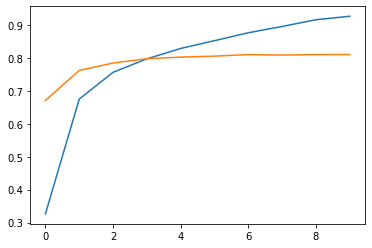

In [141]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.show()

In [142]:
total = 0
correct_count = 0
for img,labels in ds_test.take(9):
    results = model(img)
    total += labels.shape[0]
    for index,predict in enumerate(results):
        if predict.numpy().argmax() == labels[index].numpy().argmax():
            correct_count += 1
print(f'Accuracy = {correct_count/total*100} %')

Accuracy = 82.98611111111111 %
